In [6]:
# Import Library yang dibutuhkan

import numpy as np
import tensorflow as tf
import keras
import os
import zipfile

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adamax, Nadam, SGD, Adam 
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16

from matplotlib import pyplot as plt
from matplotlib import image as img

from google.colab import files

In [7]:
# Menginstall kaggle agar bisa langsung mendownload dataset di colab

!pip install -q kaggle

In [8]:
# Mengupload json file API Token user kaggle

files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [9]:
# Mendownload dataset yang digunakan dengan API Command kaggle

!kaggle datasets download -d alessiocorrado99/animals10

 99% 577M/586M [00:04<00:00, 106MB/s]
100% 586M/586M [00:04<00:00, 130MB/s]


In [10]:
# Mengekstrak file zip dataset

local_zip = 'animals10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
# Mengetahui folder kelas dataset

os.listdir('/content/raw-img')

['ragno',
 'gallina',
 'elefante',
 'scoiattolo',
 'pecora',
 'farfalla',
 'cavallo',
 'mucca',
 'cane',
 'gatto']

In [12]:
# Path dataset yang digunakan

source_path = '/content/raw-img'

In [13]:
# Menginisialisasi generator untuk augmentasi dan mengaplikasikannya untuk dataset training dan validasi

augmentation_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)
 
train_gen = augmentation_gen.flow_from_directory(
    source_path,
    target_size = (224,224),
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
) 
val_gen = augmentation_gen.flow_from_directory(
    source_path,
    target_size=(224,224),
    color_mode = 'rgb',
    batch_size = 32,
    class_mode='categorical',
    shuffle=True,
    subset = 'validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [23]:
# Membuat model dengan pre-trained model yaitu VGG dan menambahkan layer berikutnya sesuai kebutuhan

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [24]:
# Menentukan optimizer dan callback beserta parameter-parameternya

sgd = SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'sgd', 
              metrics = ['accuracy'])

filepath = 'animals.h5'

checkpoint = ModelCheckpoint(filepath, 
                             monitor = 'val_accuracy', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'max')

callback_list = [checkpoint]

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 21,140,042
Trainable params: 21,140,042
Non-trainable params: 0
__________________________________________

In [25]:
# Melatih model dengan data training dan validasi

hist = model.fit(train_gen,
                 epochs=15,
                 steps_per_epoch=100,
                 validation_data=val_gen,
                 callbacks=callback_list,
                 verbose=1)

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 2.3414 - accuracy: 0.1981
Epoch 00001: val_accuracy improved from -inf to 0.23050, saving model to animals.h5
100/100 [==============================] - 113s 1s/step - loss: 2.3414 - accuracy: 0.1981 - val_loss: 2.1746 - val_accuracy: 0.2305
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 1.9758 - accuracy: 0.3056
Epoch 00002: val_accuracy did not improve from 0.23050
100/100 [==============================] - 114s 1s/step - loss: 1.9758 - accuracy: 0.3056 - val_loss: 2.4977 - val_accuracy: 0.2217
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 1.3622 - accuracy: 0.5391
Epoch 00003: val_accuracy improved from 0.23050 to 0.74924, saving model to animals.h5
100/100 [==============================] - 112s 1s/step - loss: 1.3622 - accuracy: 0.5391 - val_loss: 0.7803 - val_accuracy: 0.7492
Epoch 4/15
100/100 [==============================] - ETA: 0s - loss: 0.9562 - accuracy: 0

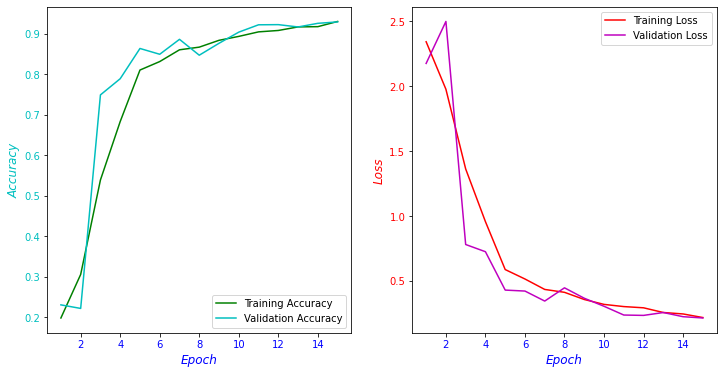

In [26]:
# Membuat plot grafik akurasi dan loss pada model selama training

n = len(hist.history['loss']) + 1
ep = np.arange(1, n, 1)

fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].set_xlabel('Epoch', style='italic', size=12, color='b')
ax[0].set_ylabel('Accuracy', style='italic', size = 12, color = 'c')
ax[0].plot(ep, hist.history['accuracy'], color = 'g')
ax[0].plot(ep, hist.history['val_accuracy'], color = 'c')
ax[0].tick_params(axis='x', labelcolor='b')
ax[0].tick_params(axis='y', labelcolor='c')
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

ax[1].set_xlabel('Epoch', style='italic', size=12, color='b')
ax[1].set_ylabel('Loss', style = 'italic', size = 12, color = 'r')
ax[1].plot(ep, hist.history['loss'], color = 'r')
ax[1].plot(ep, hist.history['val_loss'], color = 'm')
ax[1].tick_params(axis='x', labelcolor='b')
ax[1].tick_params(axis='y', labelcolor='r')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')

In [27]:
# from tensorflow.lite import TFLiteConverter

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp3eof_zwh/assets


In [28]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

Referensi

https://www.tensorflow.org/lite/convert/python_api

https://keras.io/api/optimizers/sgd/

https://www.freecodecamp.org/news/how-to-pick-the-best-learning-rate-for-your-machine-learning-project-9c28865039a8/

https://ruder.io/optimizing-gradient-descent/

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

https://keras.io/api/applications/vgg/#vgg16-function

https://www.kaggle.com/general/74235

https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

https://www.kaggle.com/aman193070021/cnn-vgg-animals10